# Adding Self-Attention to a Convolutional Neural Network

In this notebook we will see how we can add self-attention to a simple Convolutional Neural Network. Each spatial location of the feature map within the network will be able to query every other location.

Why would that be useful?

We know that convolutions operate locally over the spatial dimensions of our input. This means the receptive field of a feature in the output feature map has a receptive field of a very small part of the input. In order for the output of the very last convolution layer to have a receptive field of the whole input, we need to stack many convolution layers, hence the structure of a CNN. However this means that many convolution layers early in the network can only operate on a small part of the input.

Self-attention provides a way (with minimal parameters) to "Mix" all of the spatial locations so that all features have information about the whole input early on in the network.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

In [33]:
# The size of our mini batches
batch_size = 64

# How many iterations of our dataset
num_epochs = 10

# Optimizer learning rate
learning_rate = 1e-4

# Where to load/save the dataset from
data_set_root = "."

In [3]:
# Set device to GPU_indx if GPU is avaliable
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

## Create a transform for the input data
As we have seen, we often wish to perform some operations on data before we pass it through our model. Such operations could be data augmentation (e.g., cropping or resizing images) and data normalizations. Pytorch's torchvision module has a large number of such "transforms" which can be strung together sequentially using the "Compose" function (see [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html#) and [torchvision.transforms.AutoAugmentPolicy](https://pytorch.org/vision/main/generated/torchvision.transforms.AutoAugmentPolicy.html).

Pytorch's inbuilt datasets take a transform as an input and will apply this transform to the data before passing it on. This makes preprocessing data really easy.

In [4]:
# Prepare a composition of transforms (including data augmentation)
transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

# No data augmentation at test time!
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

## Create the training, testing and validation data

In [5]:
train_data = datasets.CIFAR10(data_set_root, train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(data_set_root, train=False, download=True, transform=test_transform)

100%|██████████| 170M/170M [00:05<00:00, 30.0MB/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


Pick subset corresponding to automobile and cat (to make notebook run faster).

In [6]:
class_indices = [1, 3] # automobile and cat

train_indices = [i for i, label in enumerate(train_data.targets) if label in class_indices]
test_indices = [i for i, label in enumerate(test_data.targets) if label in class_indices]

# Remap class indices (1->0 and 3->1)
for i in train_indices:
  label = 0 if train_data.targets[i] == 1 else 1
  train_data.targets[i] = label

for i in test_indices:
  label = 0 if test_data.targets[i] == 1 else 1
  test_data.targets[i] = label

train_data = torch.utils.data.Subset(train_data, train_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

In [7]:
# We are going to split the test dataset into a train and validation set 90%/10%
validation_split = 0.9

# Determine the number of samples for each split
n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

<h3> Check the lengths of all the datasets</h3>

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 9000
Number of validation examples: 1000
Number of testing examples: 2000


<h3> Create the dataloader</h3>

In [9]:
# Create the training, Validation and Test Datasets
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)
test_loader  = dataloader.DataLoader(test_data, batch_size=batch_size)

## Create the CNN with Self-Attention
Here, we build a simple CNN with a self-attention layer after the first convolutional layer (`conv1`).

In [10]:
class CNN(nn.Module):
    def __init__(self, channels_in):
        super(CNN, self).__init__()

        # Define Convolution Layers
        self.conv1 = nn.Conv2d(channels_in, 64, 3, 1, 1, padding_mode='reflect')

        # Define layer normalization and self-attention layers
        self.norm = nn.LayerNorm(64)
        self.mha = nn.MultiheadAttention(64, num_heads=1, batch_first=True)
        self.scale = nn.Parameter(torch.zeros(1))

        # Define additional Convolution Layers
        self.conv2 = nn.Conv2d(64, 64, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 64, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(64)

        # Define Dropout and Fully Connected Layers
        self.do = nn.Dropout(0.5)
        self.fc_out = nn.Linear(64*4*4, 2)

    def use_attention(self, x):
        # Reshape input for self-attention, i.e., flatten each image
        # from shape (C,H,W) to shape (H*W, C).
        bs, c, h, w = x.shape
        x_att = x.reshape(bs, c, h * w).transpose(1, 2)  # BSxHWxC

        # Apply layer normalization
        x_att = self.norm(x_att)

        # Apply self-attention
        att_out, att_map  = self.mha(x_att, x_att, x_att)

        return att_out.transpose(1, 2).reshape(bs, c, h, w), att_map

    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)

        # Apply self-attention mechanism and add to the input
        # (this resembles self-attention with a residual connection)
        x = self.scale * self.use_attention(x)[0] + x

        # Apply batch normalization and ReLU activation
        x = F.relu(x)

        # Additional convolutional layers
        x = F.relu(self.bn1(self.conv2(x)))
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.bn3(self.conv4(x)))

        # Flatten the output and apply dropout
        x = self.do(x.reshape(x.shape[0], -1))

        # Fully connected layer for final output
        return self.fc_out(x)


## Questions
- Consider the `use_attention` function of the above `CNN`. Why is it necessary to reshape the input from shape `(bs, c, h, w)` to shape `(bs, h*w, c)`? (hint: the self-attention diagram below might be of help).
- During the `forward` pass there is a skip connection (or residual connection) to prevent vanishing gradients (see `x = self.scale * self.use_attention(x)[0] + x`). But this is a special kind of skip connection with a learnable scaling parameter `self.scale`, which is initialized to 0. What is the role of this scaling parameter? (hint: see slides from lecture 12 on *Self-attention GAN (SAGAN)*).

![](https://www.researchgate.net/publication/342048338/figure/fig2/AS:900527554572289@1591713908214/Architecture-of-the-self-attention-block-21.png)

## Create our model and view the ouput!

In [11]:
# Create a dataloader itterable object
dataiter = next(iter(test_loader))

# Sample from the itterable object
test_images, test_labels = dataiter

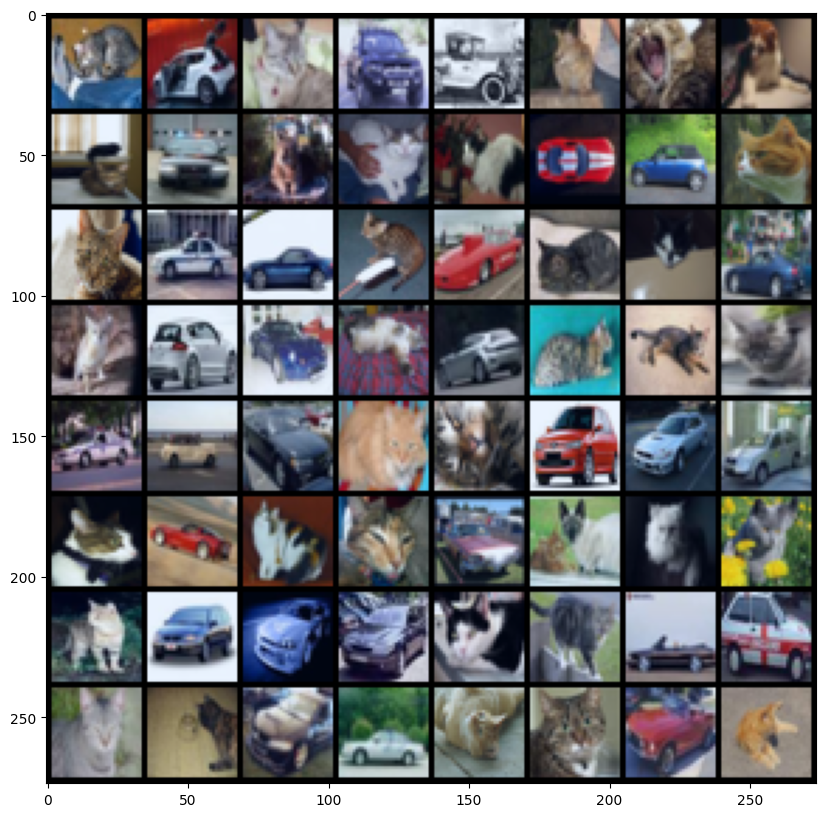

In [12]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [34]:
# Create an instance of our network
# Set channels_in to the number of channels of the dataset images (1 channel for MNIST)
model = CNN(channels_in = test_images.shape[1]).to(device)

# View the network
# Note that the layer order is simply the order in which we defined them, NOT the order of the forward pass
print(model)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do): Dropout(p=0.5, inplace=False)
  (fc_out): Linear(in_features=1024, out_features=2, bias=True)
)


In [14]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 131779 (Approximately 0 Million) Parameters!


In [15]:
# Pass image through network
out = model(test_images.to(device))

# Check output
out.shape

torch.Size([64, 2])

## Set up the optimizer

In [35]:
# Pass our network parameters to the optimiser set our lr as the learning_rate
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [36]:
# Define a Cross Entropy Loss
loss_fun = nn.CrossEntropyLoss()

## Define the training process

In [18]:
# This function should perform a single training epoch using our training data
def train(model, optimizer, loader, device, loss_fun, loss_logger):

    # Set Network in train mode
    model.train()
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
        # Forward pass of image through network and get output
        fx = model(x.to(device))

        # Calculate loss using loss function
        loss = loss_fun(fx, y.to(device))

        # Zero Gradents
        optimizer.zero_grad()
        # Backpropagate Gradents
        loss.backward()
        # Do a single optimization step
        optimizer.step()

        # Log the loss for plotting
        loss_logger.append(loss.item())

    # Return the avaerage loss and acc from the epoch as well as the logger array
    return model, optimizer, loss_logger

## Define the testing process

In [19]:
# This function should perform a single evaluation epoch, it WILL NOT be used to train our model
def evaluate(model, device, loader):

    # Initialise counter
    epoch_acc = 0

    # Set network in evaluation mode
    # Layers like Dropout will be disabled
    # Layers like Batchnorm will stop calculating running mean and standard deviation
    # and use current stored values (More on these layer types soon!)
    model.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
            # Forward pass of image through network
            fx = model(x.to(device))

            # Log the cumulative sum of the acc
            epoch_acc += (fx.argmax(1) == y.to(device)).sum().item()

    # Return the accuracy from the epoch
    return epoch_acc / len(loader.dataset)

## The training process

In [37]:
training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []

In [38]:
valid_acc = 0
train_acc = 0

# This cell implements our training loop
pbar = trange(0, num_epochs, leave=False, desc="Epoch")
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))

    # Call the training function and pass training dataloader etc
    model, optimizer, training_loss_logger = train(model=model,
                                                   optimizer=optimizer,
                                                   loader=train_loader,
                                                   device=device,
                                                   loss_fun=loss_fun,
                                                   loss_logger=training_loss_logger)

    # Call the evaluate function and pass the dataloader for both validation and training
    train_acc = evaluate(model=model, device=device, loader=train_loader)
    valid_acc = evaluate(model=model, device=device, loader=valid_loader)

    # Log the train and validation accuracies
    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)

print("Training Complete")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/141 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Training Complete


## Plot Metrics

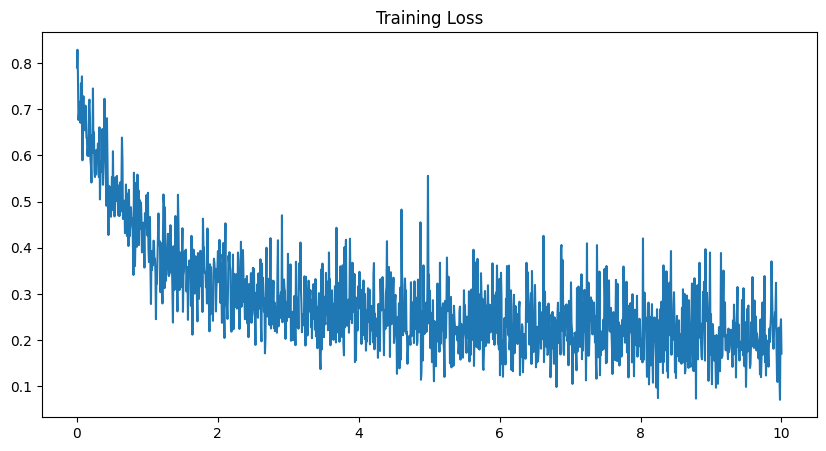

In [39]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger)
_ = plt.title("Training Loss")

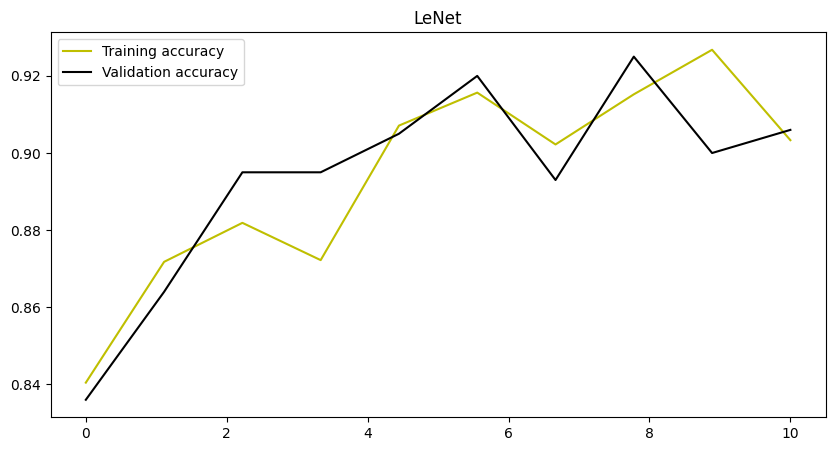

In [40]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")

plt.title("LeNet")
_ = plt.legend(["Training accuracy", "Validation accuracy"])

# Evaluate

In [41]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = evaluate(model=model, device=device, loader=test_loader)
print("The total test accuracy is: %.2f%%" %(test_acc*100))

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

The total test accuracy is: 95.30%


In [42]:
# Select some test images
test_indices = [1, 2, 3, 11, 24, 39, 61, 59]

Predicted Values
 [0, 1, 0, 1, 1, 0, 1, 0]
True Values
 [1, 1, 0, 0, 1, 1, 0, 1]


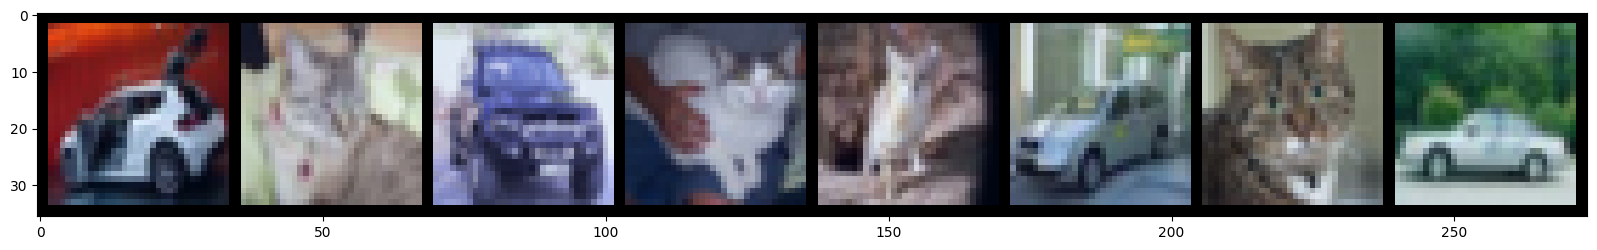

In [43]:
# Lets visualise the prediction for a few test images
with torch.no_grad():
    fx = model(test_images[test_indices].to(device))
    pred = fx.argmax(-1)

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images[test_indices], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", list(pred.cpu().numpy()))
print("True Values\n", list(test_labels[-8:].numpy()))

Display some self-attention maps for the selected test images. Recall that there is a self-attention map for each pair of query and key pixel. Here, we just select the pixels in `range(5,32,10)`. The query pixel is indicated with a red cross.

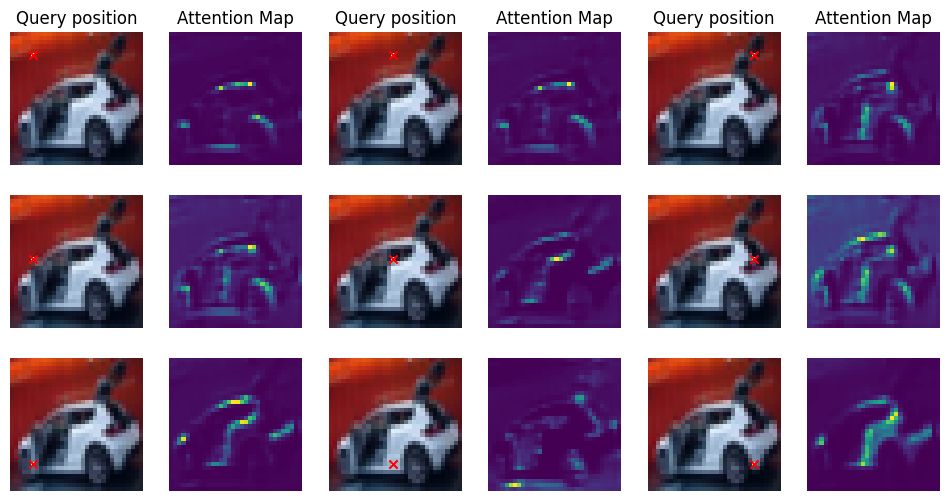

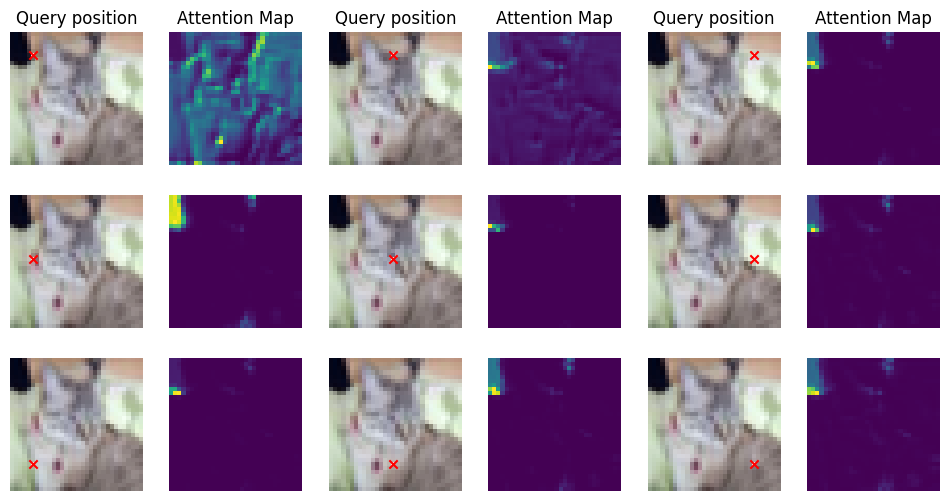

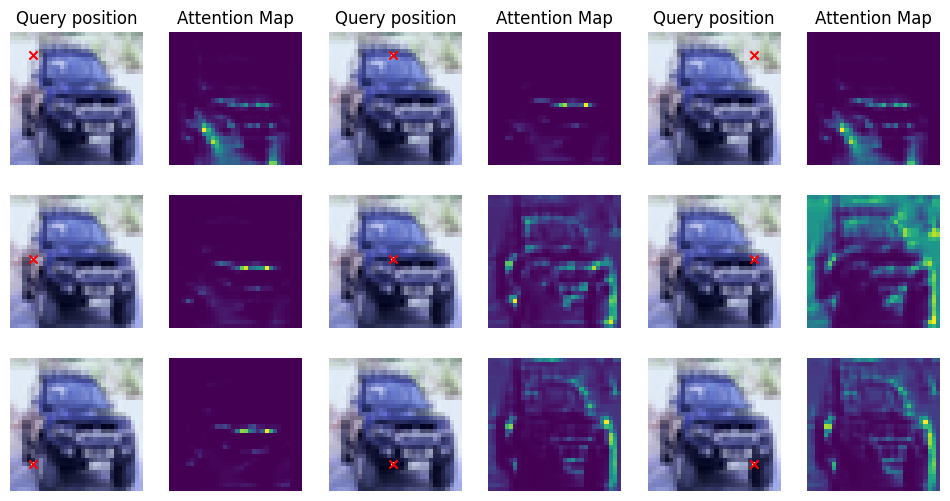

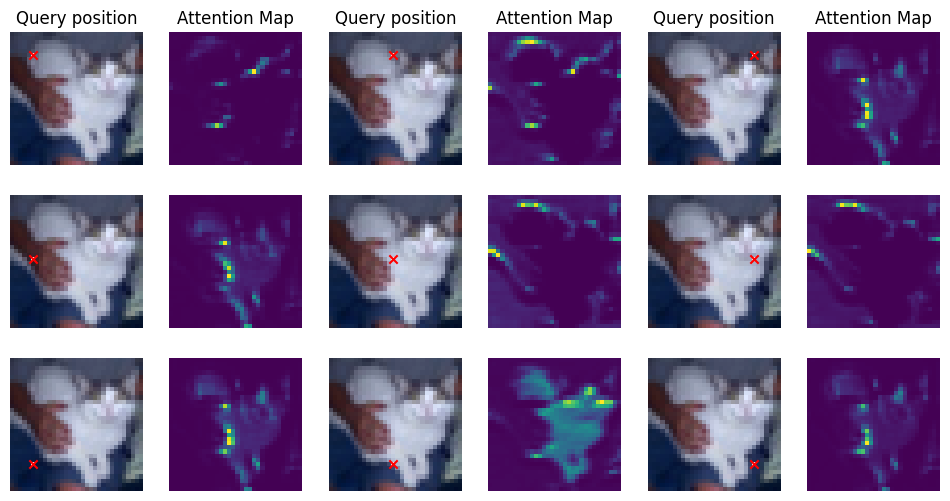

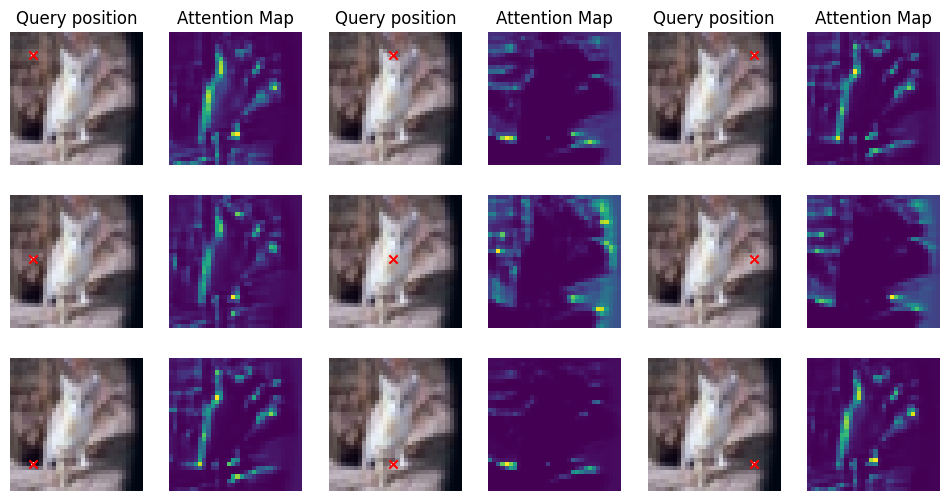

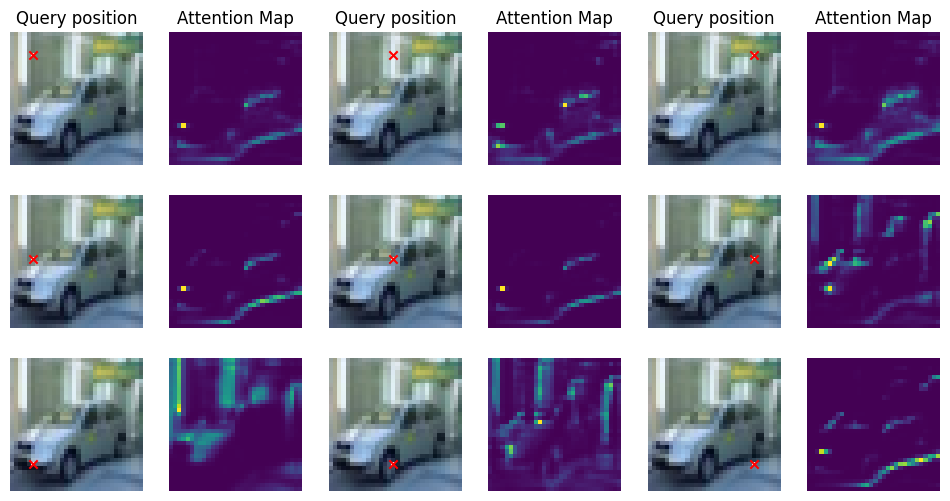

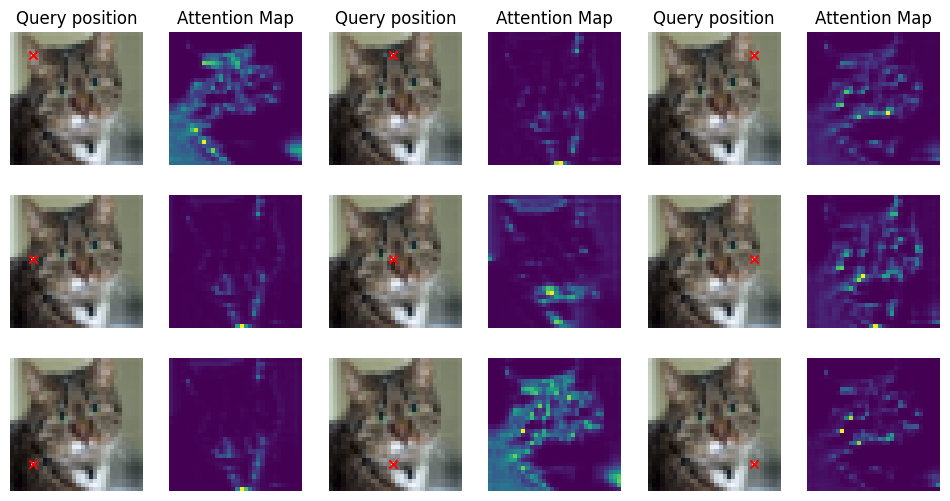

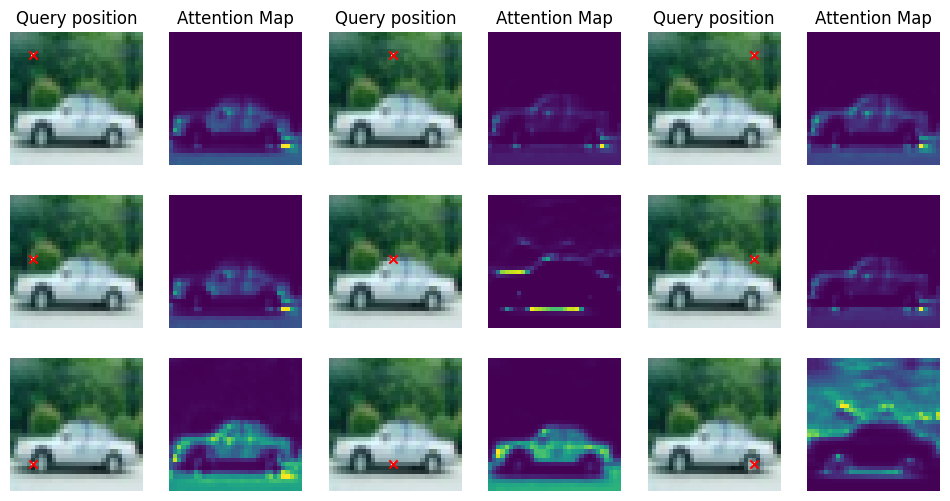

In [44]:
# The images 32x32. As a result the attention weight matrix is going to
# be (32*32)x(32*32) because all pixels attend to all other pixels.
# This will help us map between pixel coordinates and attention weights:
rows = np.tile(np.arange(32).reshape(32,1),(1,32)).reshape(32*32)
cols = np.tile(np.arange(32).reshape(1,32),(32,1)).reshape(32*32)

# Assuming model and test_images are already defined and loaded
with torch.no_grad():
    x = model.conv1(test_images[test_indices].to(device))
    _, att_map = model.use_attention(x)

for att_map_index, img_idx in enumerate(test_indices):

  plt.figure(figsize=(12,6))

  # Plot self-attention map for different pixel locations
  for i, x in enumerate(range(5,32,10)):
    for j, y in enumerate(range(5,32,10)):
      attention_map_index = x*32 + y

      row = rows[attention_map_index]
      col = cols[attention_map_index]

      # Plot the original image
      img_out = test_images[img_idx]
      img_out = (img_out - img_out.min())/(img_out.max() - img_out.min())
      img_out = img_out.permute(1, 2, 0).cpu().numpy()
      img_out[row,col,:] = 1

      plt.subplot(3,6,i*6+2*j+1)
      plt.imshow(img_out)
      if i == 0:
        plt.title("Query position")
      plt.axis('off')
      plt.scatter(y, x, color='red', marker='x')

      # Plot the attention map
      plt.subplot(3,6,i*6+2*j+2)
      plt.imshow(att_map[att_map_index, attention_map_index].reshape(32, 32).cpu().numpy(), cmap='viridis')
      if i == 0:
        plt.title("Attention Map")
      plt.axis('off')

  plt.show()